In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from eden.converter.molecule import obabel
import networkx as nx
import pybel
import requests
import os.path

In [3]:
def get_compounds(fname, size, listkey):
    PROLOG='https://pubchem.ncbi.nlm.nih.gov/rest/pug/'
    with open(fname,'w') as file_handle:
        stepsize=50
        index_start=0
        for chunk, index_end in enumerate(range(0,size+stepsize,stepsize)):
            if index_end is not 0 :
                print 'Chunk %s) Processing compounds %s to %s (of a total of %s)' % (chunk, index_start, index_end-1, size)
                RESTQ = PROLOG + 'compound/listkey/' + str(listkey) + '/SDF?&listkey_start=' + str(index_start) + '&listkey_count=' + str(stepsize)
                reply=requests.get(RESTQ)
                file_handle.write(reply.text)
            index_start = index_end
        print 'compounds available in file: ', fname


def get_assay(assay_id):
    PROLOG='https://pubchem.ncbi.nlm.nih.gov/rest/pug/'
    AID=str(assay_id)
    #active
    RESTQ = PROLOG + 'assay/aid/' + AID + '/cids/JSON?cids_type=active&list_return=listkey'
    reply=requests.get(RESTQ)
    #extract the listkey
    active_listkey = reply.json()['IdentifierList']['ListKey']
    active_size = reply.json()['IdentifierList']['Size'] 
    active_fname = 'data/AID'+AID+'_active.sdf'
    get_compounds(fname=active_fname, size=active_size, listkey=active_listkey)

    #inactive
    RESTQ = PROLOG + 'assay/aid/' + AID + '/cids/JSON?cids_type=inactive&list_return=listkey'
    reply=requests.get(RESTQ)
    #extract the listkey
    inactive_listkey = reply.json()['IdentifierList']['ListKey']
    inactive_size = reply.json()['IdentifierList']['Size']
    inactive_fname = 'data/AID'+AID+'_inactive.sdf'
    get_compounds(fname=inactive_fname, size=inactive_size, listkey=inactive_listkey)

    return (active_fname,inactive_fname)

In [4]:
%%time

AID=825
READ_FROM_FILE=True
DATA_DIR = 'data'
if READ_FROM_FILE:
    active_fname=DATA_DIR + '/AID%s_active.sdf'%AID
    inactive_fname=DATA_DIR + '/AID%s_inactive.sdf'%AID
else:
    active_fname, inactive_fname = get_assay(AID)


CPU times: user 16 µs, sys: 6 µs, total: 22 µs
Wall time: 28.1 µs


Generate conformers for data

In [5]:
%%time
# Active compounds
if not os.path.exists(DATA_DIR + '/conf_AID%s_active.sdf'%AID):
    obabel.generate_conformers(active_fname, active_conf, 10, 'rmsd')
# Inactive compounds
if not os.path.exists(DATA_DIR + '/conf_AID%s_inactive.sdf'%AID):
    obabel.generate_conformers(active_fname, inactive_conf, 10, 'rmsd')

CPU times: user 163 µs, sys: 70 µs, total: 233 µs
Wall time: 164 µs


Functions for training and testing the model

In [8]:
import datetime, time
def train_obabel_model(pos_fname, neg_fname, model_type = "default",
                       model_fname=None, n_iter=40, active_set_size=1000, 
                       n_active_learning_iterations=3, threshold=1, train_test_split=0.7, 
                       verbose=False):
    
    from numpy.random import randint
    from numpy.random import uniform
    
    # this will be passed as an argument to the model later on
    def pre_processor( data, **args):
        return data
    
    from eden.graph import Vectorizer
    #vectorizer_parameters={'complexity':[1,2,3,4],
    #                       'discretization_size':randint(3, 100,size=n_iter),
    #                       'discretization_dimension':randint(3, 50, size=n_iter)}
    vectorizer_parameters={'complexity':[1,2,3,4],
                           'discretization_size':3,
                           'discretization_dimension':3}
    vectorizer = Vectorizer(**vectorizer_parameters)

    from sklearn.linear_model import SGDClassifier
    estimator = SGDClassifier(class_weight='auto', shuffle=True)

    #create iterable from files
    from eden.converter.molecule import obabel
    if model_type == "default":
        iterable_pos=obabel.obabel_to_eden(pos_fname)
        iterable_neg=obabel.obabel_to_eden(neg_fname)
    elif model_type == "3d":
        iterable_pos=obabel.obabel_to_eden3d(pos_fname)
        iterable_neg=obabel.obabel_to_eden3d(neg_fname)

    
    from itertools import tee
    iterable_pos, iterable_pos_ = tee(iterable_pos)
    iterable_neg, iterable_neg_ = tee(iterable_neg)
    
    import time
    start = time.time()
    print('# positives: %d  # negatives: %d (%.1f sec %s)'%(sum(1 for x in iterable_pos_), sum(1 for x in iterable_neg_), time.time() - start, str(datetime.timedelta(seconds=(time.time() - start)))))
    
    iterable_pos, iterable_pos_ = tee(iterable_pos)
    iterable_neg, iterable_neg_ = tee(iterable_neg)
    
    vectorizer.fit(iterable_pos_)
    #split train/test
    from eden.util import random_bipartition_iter
    iterable_pos_train, iterable_pos_test = random_bipartition_iter(iterable_pos, relative_size=train_test_split)
    iterable_neg_train, iterable_neg_test = random_bipartition_iter(iterable_neg, relative_size=train_test_split)



    #make predictive model
    from eden.model import ActiveLearningBinaryClassificationModel
    model = ActiveLearningBinaryClassificationModel( pre_processor, estimator=estimator, vectorizer=vectorizer )

    #optimize hyperparameters and fit model

    pre_processor_parameters={} 

    vectorizer_parameters={'complexity':[4]}
    
    estimator_parameters={'n_iter':randint(5, 100, size=n_iter),
                          'penalty':['l1','l2','elasticnet'],
                          'l1_ratio':uniform(0.1,0.9, size=n_iter), 
                          'loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
                          'power_t':uniform(0.1, size=n_iter),
                          'alpha': [10**x for x in range(-8,-2)],
                          'eta0': [10**x for x in range(-4,-1)],
                          'learning_rate': ["invscaling", "constant", "optimal"]}

    model.optimize(iterable_pos_train, iterable_neg_train, 
                   model_name=model_fname,
                   fit_vectorizer=True,
                   n_active_learning_iterations=n_active_learning_iterations,
                   size_positive=-1,
                   size_negative=active_set_size,
                   n_iter=n_iter, cv=3, n_jobs=1, verbose=verbose,
                   pre_processor_parameters=pre_processor_parameters, 
                   vectorizer_parameters=vectorizer_parameters, 
                   estimator_parameters=estimator_parameters)
  
    #estimate predictive performance
    #model.estimate( iterable_pos_test, iterable_neg_test, cv=5 )
    # Had to change this call, estimate has no cv parameter
    model.estimate( iterable_pos_test, iterable_neg_test )
    
    return model

def test_obabel_model(fname, model_type = "default", model_fname=None):
    from eden.model import ActiveLearningBinaryClassificationModel

    model = ActiveLearningBinaryClassificationModel()
    model.load(model_fname)

    #create iterable from files
    from eden.converter.molecule import obabel
    if model_type == "default":
        iterable=obabel.obabel_to_eden(fname)
    elif model_type == "3d":
        iterable=obabel.obabel_to_eden3d(fname)
    
    predictions= model.decision_function( iterable )
        
    return predictions

Train the models

**3D model**
---

In [11]:
%%time
model_fname='AID%s.model3d'%AID
model = train_obabel_model(active_fname, inactive_fname,
                           model_type = "3d",
                           model_fname=model_fname,
                           n_iter=40, 
                           active_set_size=500, 
                           n_active_learning_iterations=0, 
                           threshold=1, 
                           train_test_split=0.8, 
                           verbose=1)

# positives: 48  # negatives: 50 (10.1 sec 0:00:10.068071)

Iteration: 1/40 (at 28.3 sec; 0:00:28.291426)
Best score (roc_auc): 0.588775 (0.642341 +- 0.053566)
Instances: 78 ; Features: 1048577 with an avg of 1950 features per instance
class: 1 count:38 (0.49)	class: -1 count:40 (0.51)	

Iteration: 3/40 (at 82.5 sec; 0:01:22.467440)
Best score (roc_auc): 0.602408 (0.677585 +- 0.075177)
Instances: 78 ; Features: 1048577 with an avg of 1950 features per instance
class: 1 count:38 (0.49)	class: -1 count:40 (0.51)	

Iteration: 5/40 (at 136.5 sec; 0:02:16.456112)
Best score (roc_auc): 0.612952 (0.670189 +- 0.057236)
Instances: 78 ; Features: 1048577 with an avg of 1950 features per instance
class: 1 count:38 (0.49)	class: -1 count:40 (0.51)	

Iteration: 9/40 (at 235.3 sec; 0:03:55.337412)
Best score (roc_auc): 0.625615 (0.631211 +- 0.005596)
Instances: 78 ; Features: 1048577 with an avg of 1950 features per instance
class: 1 count:38 (0.49)	class: -1 count:40 (0.51)	

Iteration: 23/40 (at 6

**Original model**
---

In [13]:
%%time
model_fname='AID%s.modeld'%AID
model = train_obabel_model(active_fname, inactive_fname,
                           model_type = "default",
                           model_fname=model_fname,
                           n_iter=40, 
                           active_set_size=500, 
                           n_active_learning_iterations=0, 
                           threshold=1, 
                           train_test_split=0.8, 
                           verbose=1)

# positives: 48  # negatives: 50 (0.3 sec 0:00:00.303805)

Iteration: 1/40 (at 9.1 sec; 0:00:09.103570)
Best score (roc_auc): 0.570235 (0.598056 +- 0.027820)
Instances: 78 ; Features: 1048577 with an avg of 587 features per instance
class: 1 count:38 (0.49)	class: -1 count:40 (0.51)	

Iteration: 8/40 (at 69.8 sec; 0:01:09.839497)
Best score (roc_auc): 0.578009 (0.606932 +- 0.028922)
Instances: 78 ; Features: 1048577 with an avg of 587 features per instance
class: 1 count:38 (0.49)	class: -1 count:40 (0.51)	

Iteration: 19/40 (at 169.7 sec; 0:02:49.749951)
Best score (roc_auc): 0.597585 (0.603198 +- 0.005613)
Instances: 78 ; Features: 1048577 with an avg of 587 features per instance
class: 1 count:38 (0.49)	class: -1 count:40 (0.51)	
Classifier:
SGDClassifier(alpha=1e-06, class_weight='auto', epsilon=0.1, eta0=0.0001,
       fit_intercept=True, l1_ratio=0.85681387657853947,
       learning_rate='invscaling', loss='squared_hinge', n_iter=13,
       n_jobs=1, penalty='l1', power_t=0.51054

Test the models:

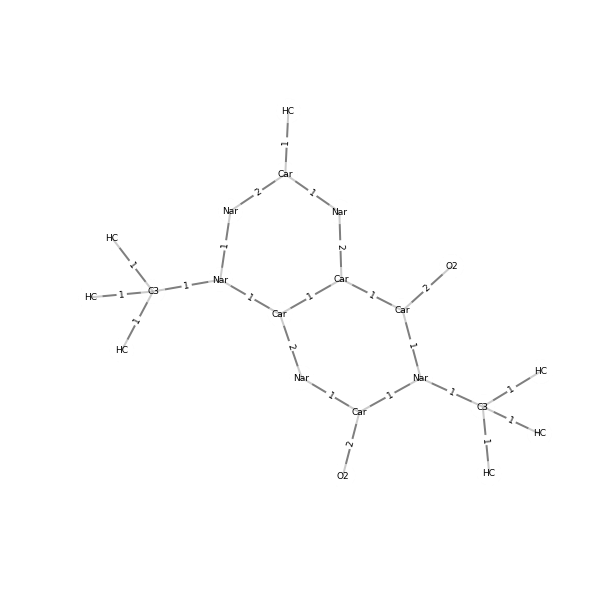

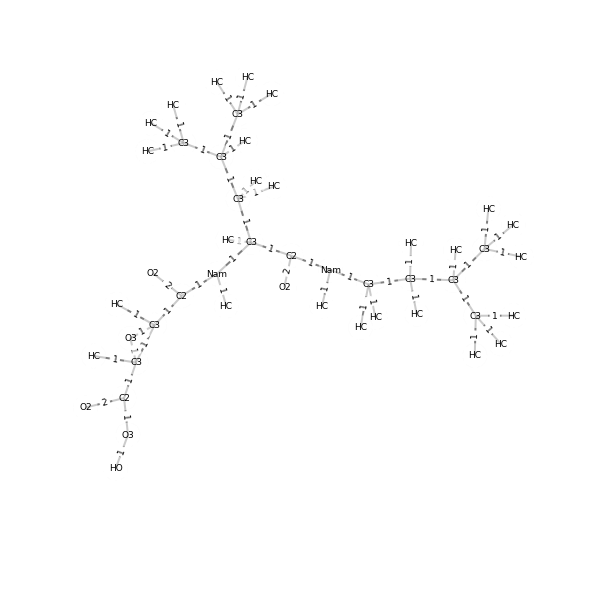

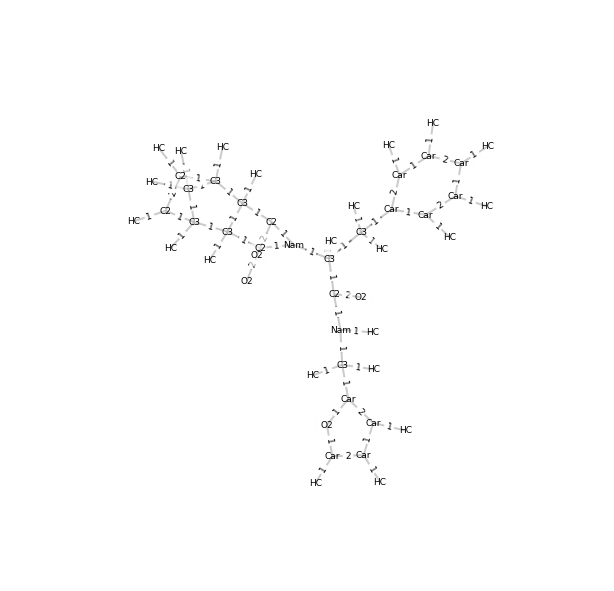

In [14]:
%matplotlib inline
from eden.util.display import draw_graph
from itertools import islice

for G in islice(iterable_pos, 3):
    draw_graph(G, vertex_label="atom_type")